# Notebook for developing diffrax/JAX based reconstruction package for XNH

In [91]:
import diffrax as dx
from diffrax.functional import *
from diffrax import LightField
from diffrax.utils import OpticalElement, OpticalLayer

import jax.numpy as jnp
from jax import random
import jax

from einops import rearrange, repeat, reduce
from flax.traverse_util import flatten_dict
from flax.core import unfreeze
import flax.linen as nn

from typing import Tuple, Callable, Sequence, Union
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

Let's define some aspects of our system (based on CBxs_lobV_top_30nm at ESRF beamline i16a):

In [42]:
du = 0.03 # effective pixel size of detector (microns) (note: documented as pixelsize_detector = 3e-6 in ESRF script?)
z_total = 1.208 * 1000 # distance from focus point to detector (microns)
zs_f2s = jnp.array([0.012080, 0.012598, 0.014671, 0.018975]) * 1000 # distances source to sample (microns) 
dz = 1. # depth of slice in microns
zs_s2d = z_total - zs_f2s - dz # distances sample to detector (microns) 
lambda_ =  7.25146e-5 # wavelength in microns for 17kEV (~3.62573e-05 um for 33kEV)
lambda_ratios = 1.0 # ratio of wavelengths
n = 0.999999999 # refractive index of x-rays is slightly below unity according to ESRF

Get and display Siemens star test object (then make it into a phase object)

(1, 1024, 1024, 1)


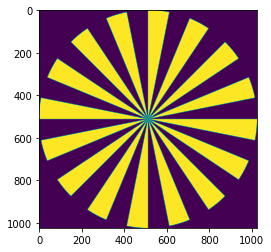

In [43]:
data = plt.imread('/n/groups/htem/users/jlr54/raygun/diffrax/Siemens_star.svg.png')
# data = repeat(jnp.abs(jnp.mean(data, axis=-1)), 'h w -> b h w 1', b = zs_f2s.size) 
data = jnp.expand_dims(jnp.expand_dims(jnp.abs(jnp.mean(data, axis=-1)), 0), -1) # 'h w -> b h w 1'
print(data.shape)
plt.imshow(data[0,...,0].squeeze())

In [44]:
# delta and beta should be 4d Tensors
delta = data * 1.2600 # phase change
beta = data * 0.98200 # extinction

Now let's make the lightfields hitting the sample and display their intensity and phase:

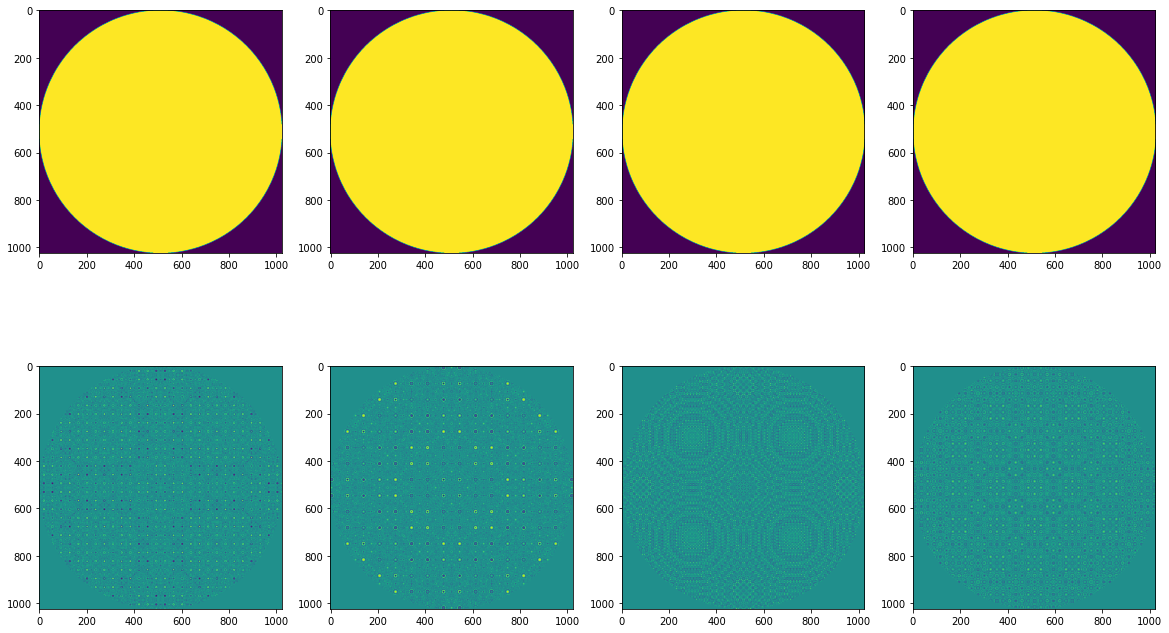

In [45]:
n_pixels = data.shape[1]
D = n_pixels * du
in_fields = [pointsource((n_pixels, du), z0, D, n, lambda_, lambda_ratios) for z0 in zs_f2s]

def show_fields(fields):
    _, axs = plt.subplots(2, len(fields), figsize=(20, 3*len(fields)))
    for i, ax in enumerate(axs.T):
        ax[0].imshow(fields[i].intensity.squeeze())
        ax[1].imshow(fields[i].phase.squeeze())

show_fields(in_fields)

Now let's make some projections:

In [46]:
def phasechange_cache(field: LightField, delta: jnp.ndarray, beta: jnp.ndarray, dz: float) -> Tuple[jnp.ndarray]:
    k = 2 * jnp.pi / field.spectrum.wavelength
    phase_factor = jnp.exp(-1j * k * dz * (delta - 1j * beta))
    return (phase_factor,)


def phasechange_apply(field: LightField, cache: Tuple[jnp.ndarray]) -> LightField:
    (phase_factor,) = cache
    u = field.u * phase_factor
    return field.replace(u=u)

# Register as functions and layers:
phasechange = OpticalElement(phasechange_apply, phasechange_cache)
PhaseChange = OpticalLayer.init_layer("phase change", phasechange)

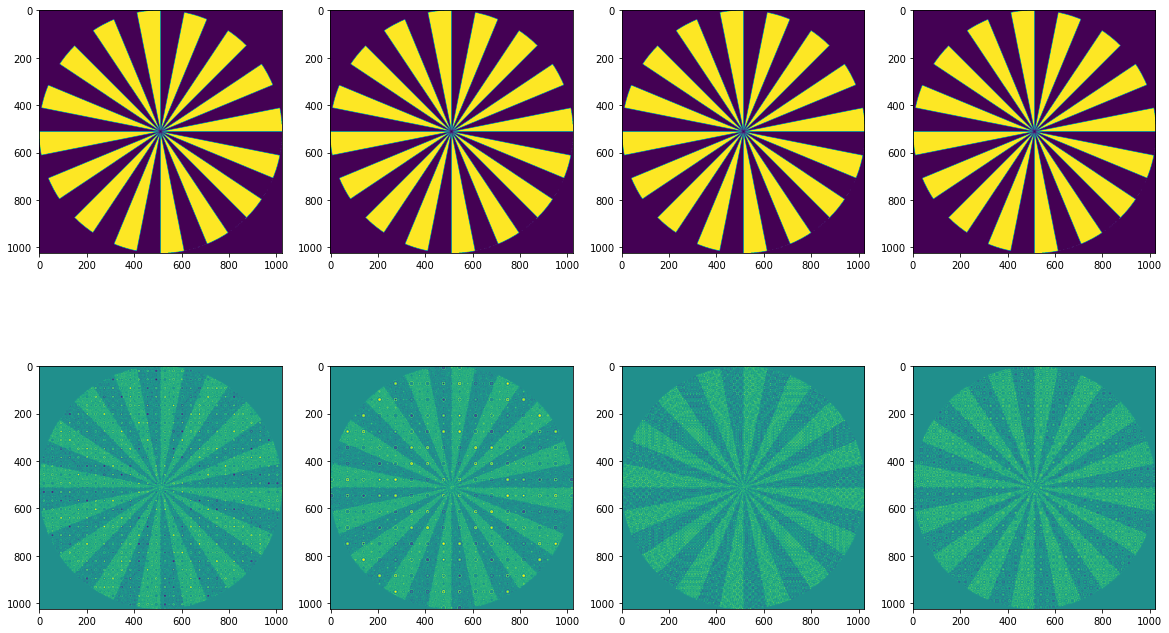

In [47]:
out_fields = [phasechange(in_field, delta, beta, dz=dz) for in_field in in_fields]
show_fields(out_fields)

Let's add free space propagation after the sample:

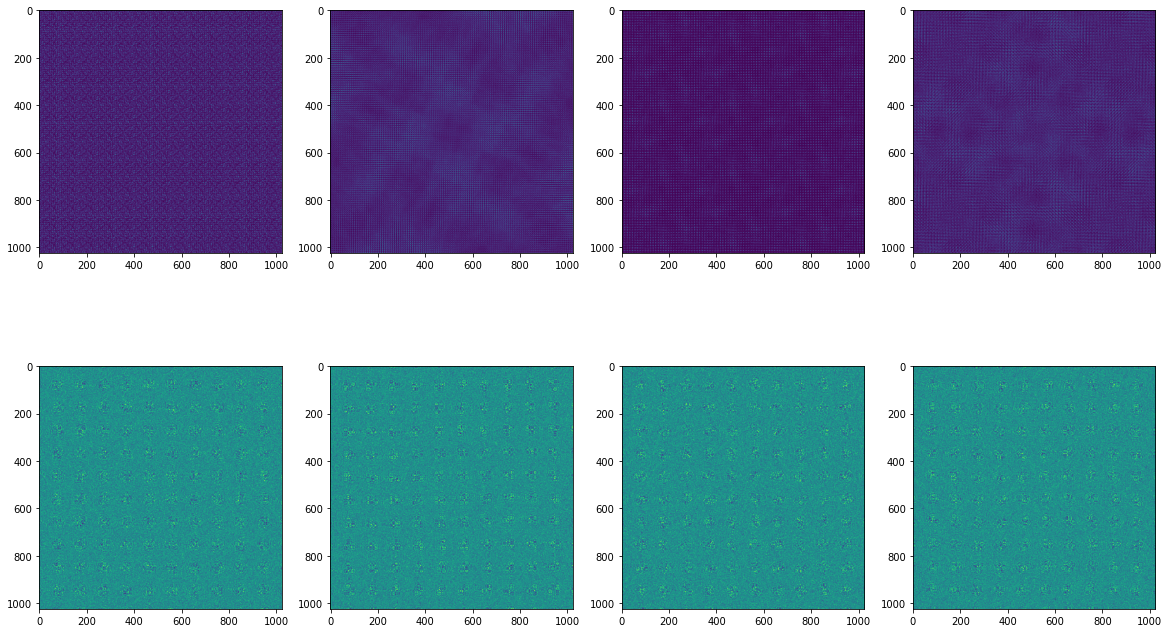

In [48]:
def propagate(field, dz, n, D): # here dz is distance to propogate wave
    Nf = jnp.max((D / 2) ** 2 / (field.spectrum.wavelength * dz))
    M = field.u.shape[1]
    Q = M / (4 * Nf)
    N = int(jnp.ceil((Q * M) / 2) * 2)
    N_pad = int((N - M) / 2)
    return transform_propagate(field, z=dz, n=n, N_pad=1024)

sensor_fields = [propagate(in_field, z_s2d, n, D) for in_field, z_s2d in zip(out_fields, zs_s2d)]
sensor_images = [sensor_field.intensity for sensor_field in sensor_fields] # these would be the sensor readings for each distance
show_fields(sensor_fields)

### Now let's see if we can reconstruct the sample from the sensor images

First, let's make some necessary variables, including making objects for parts of our imaging system.
Let's first remember the elements of our system, using the thin slice approximation for modeling the sample volume:
1) ```source```: Coherent monochromatic X-ray beam of wavelength ```lambda_``` and refractive index ```n``` in the system, focused by Kirkpatrick-Baez mirrors distances ```[zs_f2s]``` from the sample, and distance ```z_total``` from the detector/sensor.
2) ```phase_object```: The sample volume to estimate, modeled as a thin phase object with ```delta``` refractive index and ```beta``` extinction coefficient, ```[zs_f2s]``` from the beam focal point, and ```[zs_s2d]``` from the detector, with depth ```dz```.
3) ```propagation```: Propgation of the beam exiting the ```phase_object``` some ```[zs_s2d]``` distances to the detector/sensor, which should have some shot noise/manufacturing defects that produces the final images. TODO: Add noise OR **make sensor object incorporating noise/response model**

In [135]:
# Here's some classes that should likely be added to diffrax.sources for us to use:
class PointSource(nn.Module):
    args: dict

    @nn.compact
    def __call__(self, X, z):
        # we use a variable to cache the field
        field = self.variable(
            "field",
            "source",
            lambda X, z, kwargs: pointsource(X, z, **kwargs),
            X,
            z,
            self.args,
        )
        return field.value


class BeamLine(nn.Module):
    layers: Sequence[nn.Module]

    @nn.compact
    def __call__(self, *layer_args):
        # Propagating lightfield
        field = self.layers[0](*layer_args[0])  # field init layer, layer_args[0] should be non-keyword args to first layer
        for layer, args in zip(self.layers[1:], layer_args[1:]): # layer_args[>0] should be dicts of args to pass to each layer
            layer.args.update(args)
            field = layer(field)
        return field.intensity, field.grid



In [136]:
xi = jnp.linspace(-1.1 * D/2, 1.1* D/2, num=n_pixels) # zero padding on both sides
X = (xi, xi) # x and y coordinates

# in_fields = [pointsource((n_pixels, du), z0, D, n, lambda_, lambda_ratios) for z0 in zs_f2s]
source = PointSource({'D': D, 'n': n, "lambda_": lambda_, "lambda_ratios": lambda_ratios}) # takes (n_pixels, du) and z = z_f2s = z_total - z_s2d - dz

# phasechange(in_field, delta, beta, dz=dz)
phase_object = PhaseChange({'delta': delta, 'beta': beta, 'dz': dz}, trainable=(True, True, False,)) # takes LightField

# transform_propagate(field, z=dz, n=n, N_pad=1024)
propagation = dx.TransFormPropagate({'n': n, 'N_pad': 1024}) # takes LightField, and z = z_s2d = z_total - z_f2s - dz
# propagation = dx.TransFormPropagate({'z': zs_s2d[0], 'n': n, 'N_pad': 1024}) # takes LightField, and z = z_s2d = z_total - z_f2s - dz

system = BeamLine([source, phase_object, propagation])

# scope = dx.Microscope(dx.OpticalSystem([source, phase_object, propagation]),
#                     noise_fn = dx.functional.approximate_shot_noise,
#                     # reduce_fn=lambda x: reduce(x, "d h w c -> 1 h w c", "sum"),
#                     )

In [137]:
key = random.PRNGKey(42)
variables = system.init(key, [(n_pixels, du), zs_f2s[0]], {}, {'z': zs_s2d[0]})
